In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import rasterio
from rasterio.sample import sample_gen
from src.mplstyle import set as set_mplstyle

set_mplstyle("Fira Sans")

DATA_DOC_PATH = Path("./data/dataset_docs/")
OUTPUT_PATH = Path("./output/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

final_stations = pd.read_csv(DATA_DOC_PATH / "pt_stations_ge30y_80pct_good.csv")

KOPPEN_DATA = {
        1:  ('Af - Tropical, rainforest', [0, 0, 255]),
        2:  ('Am - Tropical, monsoon', [0, 120, 255]),
        3:  ('Aw - Tropical, savannah', [70, 170, 250]),
        4:  ('BWh - Arid, desert, hot', [255, 0, 0]),
        5:  ('BWk - Arid, desert, cold', [255, 150, 150]),
        6:  ('BSh - Arid, steppe, hot', [245, 165, 0]),
        7:  ('BSk - Arid, steppe, cold', [255, 220, 100]),
        8:  ('Csa - Temperate, dry summer, hot summer', [255, 255, 0]),
        9:  ('Csb - Temperate, dry summer, warm summer', [200, 200, 0]),
        10: ('Csc - Temperate, dry summer, cold summer', [150, 150, 0]),
        11: ('Cwa - Temperate, dry winter, hot summer', [150, 255, 150]),
        12: ('Cwb - Temperate, dry winter, warm summer', [100, 200, 100]),
        13: ('Cwc - Temperate, dry winter, cold summer', [50, 150, 50]),
        14: ('Cfa - Temperate, no dry season, hot summer', [200, 255, 80]),
        15: ('Cfb - Temperate, no dry season, warm summer', [100, 255, 80]),
        16: ('Cfc - Temperate, no dry season, cold summer', [50, 200, 0]),
        17: ('Dsa - Cold, dry summer, hot summer', [255, 0, 255]),
        18: ('Dsb - Cold, dry summer, warm summer', [200, 0, 200]),
        19: ('Dsc - Cold, dry summer, cold summer', [150, 50, 150]),
        20: ('Dsd - Cold, dry summer, very cold winter', [150, 100, 150]),
        21: ('Dwa - Cold, dry winter, hot summer', [170, 175, 255]),
        22: ('Dwb - Cold, dry winter, warm summer', [90, 120, 220]),
        23: ('Dwc - Cold, dry winter, cold summer', [75, 80, 180]),
        24: ('Dwd - Cold, dry winter, very cold winter', [50, 0, 135]),
        25: ('Dfa - Cold, no dry season, hot summer', [0, 255, 255]),
        26: ('Dfb - Cold, no dry season, warm summer', [55, 200, 255]),
        27: ('Dfc - Cold, no dry season, cold summer', [0, 125, 125]),
        28: ('Dfd - Cold, no dry season, very cold winter', [0, 70, 95]),
        29: ('ET - Polar, tundra', [178, 178, 178]),
        30: ('EF - Polar, frost', [102, 102, 102])
    }

In [2]:
def create_koppen_colormap():
    """
    Create a custom colormap for Köppen climate classifications
    """
    
    # Create color list (normalized to 0-1 range)
    colors = []
    labels = []
    values = []
    
    for value in range(1, 31):
        label, rgb = KOPPEN_DATA[value]
        colors.append([c/255.0 for c in rgb])  # Normalize RGB to 0-1
        labels.append(label)
        values.append(value)
    cmap = mcolors.ListedColormap(colors)
    return cmap, labels, values


def extract_climate_classification(stations_df, raster_path, lat_col='Lat', lon_col='Lon'):
    """
    Extract climate classification values from raster data at station locations
    
    Parameters:
    -----------
    stations_df : pandas.DataFrame
        DataFrame containing station information with latitude and longitude columns
    raster_path : str
        Path to the Köppen climate classification raster file
    lat_col : str
        Name of the latitude column (default: 'Lat')
    lon_col : str
        Name of the longitude column (default: 'Lon')
    
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with added 'KG' column containing climate classification values
    """
    
    # Make a copy of the original dataframe
    stations_copy = stations_df.copy()
    
    # Open the raster file
    with rasterio.open(raster_path) as src:
        coords = [(lon, lat) for lon, lat in zip(stations_copy[lon_col], stations_copy[lat_col])]
        
        # Sample the raster at the coordinate locations
        sampled_values = [val[0] for val in sample_gen(src, coords)]

        stations_copy['KG'] = sampled_values
        stations_copy['KG'] = stations_copy['KG'].astype('Int64') 
    return stations_copy

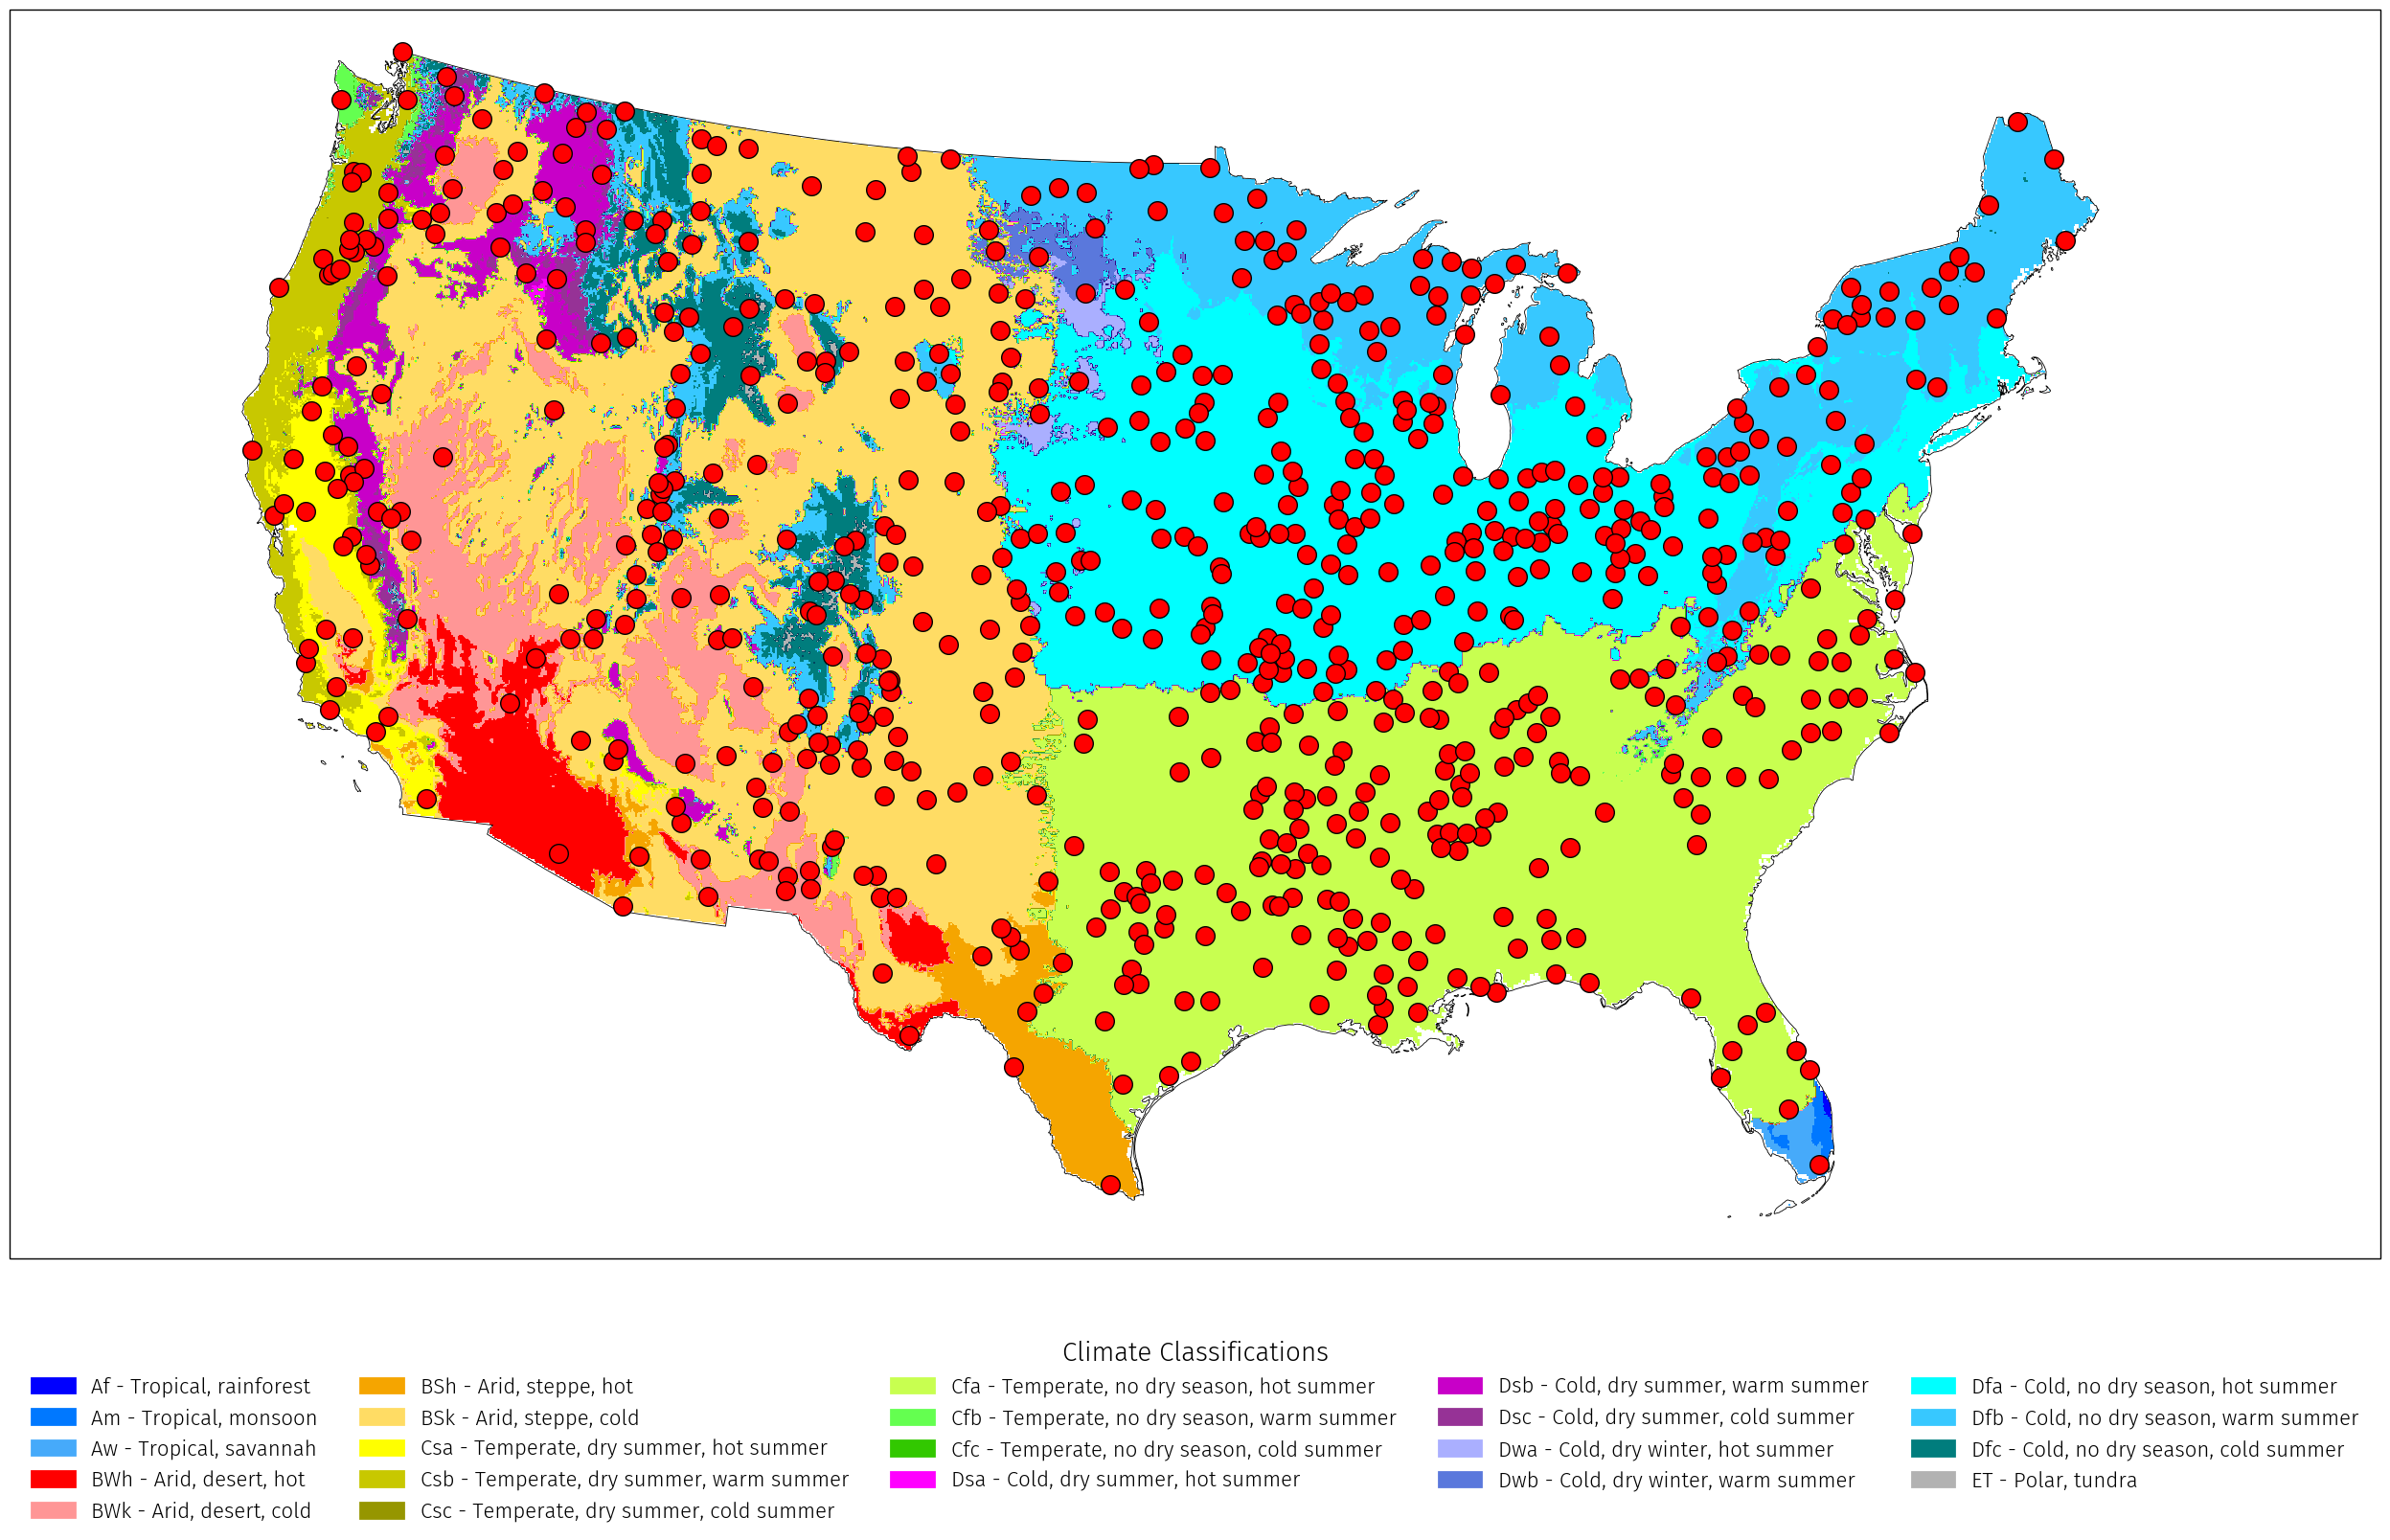

In [3]:
raster_path = "./data/CONUS_Beck_KG_V1_Present.tif"
proj_5070 = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=23, 
                                    false_easting=0.0, false_northing=0.0, 
                                    standard_parallels=(29.5, 45.5))
extent = [-125, -66.75, 24.5, 49.5]
cmap, labels, values = create_koppen_colormap()

with rasterio.open(raster_path) as src:
    data = src.read(1)
    data_masked = np.ma.masked_where(data == 0, data)
    fig, ax = plt.subplots(figsize=(14, 9), subplot_kw={'projection': proj_5070})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    im = ax.imshow(data_masked, cmap=cmap, vmin=0.5, vmax=30.5, 
                    extent=[src.bounds.left, src.bounds.right, 
                            src.bounds.bottom, src.bounds.top],
                    transform=ccrs.PlateCarree())
    
    bnd = gpd.read_file('data/shp/CONUS_boundary.shp')
    ax.add_geometries(bnd.geometry, crs=ccrs.PlateCarree(), 
                color='none', edgecolor="k", linewidth=0.3, zorder=2)
    
    # Stations
    for i, station in final_stations.iterrows():
        ax.scatter(
            x=station["Lon"],
            y=station["Lat"],
            transform=ccrs.PlateCarree(),
            edgecolors="k",
            color="red",
            s=50,
            zorder=10,
            linewidths=0.5,
        )

    # Legend
    unique_values = np.unique(data[~np.isnan(data)])
    legend_patches = []

    for val in sorted(unique_values):
        if 1 <= val <= 30:
            idx = int(val) - 1
            color = cmap.colors[idx]
            label = labels[idx]
            legend_patches.append(Patch(color=color, label=label))
    
    ax.legend(handles=legend_patches, 
                bbox_to_anchor=(0.5, -0.05), 
                loc='upper center',
                fontsize=8,
                title='Climate Classifications',
                ncol=5,
                title_fontsize=10)
    

    plt.tight_layout()
    fig.savefig(OUTPUT_PATH / "figures/stations_KG.pdf", dpi=300, format="pdf")
    plt.show()


In [10]:
final_stations = extract_climate_classification(final_stations, raster_path, "Lat", "Lon")
#final_stations.to_csv(DATA_DOC_PATH / "pt_stations_ge30y_80pct_good.csv", index=False)

In [11]:
kg_descriptions = {
            1: 'Af - Tropical, rainforest',
            2: 'Am - Tropical, monsoon',
            3: 'Aw - Tropical, savannah',
            4: 'BWh - Arid, desert, hot',
            5: 'BWk - Arid, desert, cold',
            6: 'BSh - Arid, steppe, hot',
            7: 'BSk - Arid, steppe, cold',
            8: 'Csa - Temperate, dry summer, hot summer',
            9: 'Csb - Temperate, dry summer, warm summer',
            10: 'Csc - Temperate, dry summer, cold summer',
            11: 'Cwa - Temperate, dry winter, hot summer',
            12: 'Cwb - Temperate, dry winter, warm summer',
            13: 'Cwc - Temperate, dry winter, cold summer',
            14: 'Cfa - Temperate, no dry season, hot summer',
            15: 'Cfb - Temperate, no dry season, warm summer',
            16: 'Cfc - Temperate, no dry season, cold summer',
            17: 'Dsa - Cold, dry summer, hot summer',
            18: 'Dsb - Cold, dry summer, warm summer',
            19: 'Dsc - Cold, dry summer, cold summer',
            20: 'Dsd - Cold, dry summer, very cold winter',
            21: 'Dwa - Cold, dry winter, hot summer',
            22: 'Dwb - Cold, dry winter, warm summer',
            23: 'Dwc - Cold, dry winter, cold summer',
            24: 'Dwd - Cold, dry winter, very cold winter',
            25: 'Dfa - Cold, no dry season, hot summer',
            26: 'Dfb - Cold, no dry season, warm summer',
            27: 'Dfc - Cold, no dry season, cold summer',
            28: 'Dfd - Cold, no dry season, very cold winter',
            29: 'ET - Polar, tundra',
            30: 'EF - Polar, frost'
        }

#final_stations["KG"] = final_stations["KG"].map(kg_descriptions)
final_stations["KG"].value_counts()

KG
14    184
25    183
7     149
26     80
5      28
9      27
18     17
8      12
6       7
21      5
27      5
4       4
22      3
0       3
19      2
15      2
17      1
3       1
Name: count, dtype: Int64

In [6]:
final_stations["KG"].value_counts().to_csv(DATA_DOC_PATH / "kg_counts.csv")